# Initiating the environment

Before any SARIMA model can be implemented, the python environment needs to be initialized. This is done by importing the relevant packages and setting some global variables.

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib as mpl

import statsmodels.api as sm


In [4]:
machine = 'local'

if machine == 'Snellius':
    # For retrieving the set of aggregated scaling vectors
    PRED_VAR_PATH = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/'

    # used for storing the trained model
    SAVE_DIR = pers_file_dir = '/gpfs/work1/0/ctdas/awoude/Ritten/trained_models/'

    # used for storing the scaling factor produced bij ML models
    SF_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/fitted_sf/'

    # used for storing the trained model
    RESULTS_DIR = '/gpfs/work1/0/ctdas/awoude/Ritten/results/'

elif machine == 'local':
    PRED_VAR_PATH = './data_files/'  # For retrieving the set of aggregated scaling vectors

    SAVE_DIR = pers_file_dir = './trained_models/'  # used for storing the trained model

    SF_DIR = './fitted_sf/'  # used for storing the scaling factor produced bij ML models

    RESULTS_DIR = './results/'

FIG_DIR = '../figures/'

The data used for fitting the model is loaded afterwards. Note that not all data is used, as we want to set aside some 'clean' data for the final testing of our models.

In [5]:
with xr.open_dataset(PRED_VAR_PATH + 'vars_per_eco_update.nc') as ds:
    complete_ds = ds

# before moving forward, some data is put aside to be used for model validation later. Going for the classical 80-20% split
train_ds = complete_ds.loc[dict(time=slice("2000-01-01","2017-01-01"))]
print(train_ds)


<xarray.Dataset>
Dimensions:           (time: 888, lon: 360, lat: 180, eco_regions: 68)
Coordinates:
  * time              (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2016-12-31
  * lon               (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat               (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * eco_regions       (eco_regions) float64 1.0 3.0 4.0 ... 204.0 206.0 209.0
Data variables: (12/50)
    regions           (lat, lon) float32 ...
    grid_cell_weight  (lat, lon) float64 ...
    grid_cell_area    (lat, lon) float32 ...
    TER               (lat, lon) float64 ...
    monthly_flux      (eco_regions, time) float64 ...
    smoothed_flux     (eco_regions, time) float64 ...
    ...                ...
    sd_MIN            (eco_regions, time) float64 ...
    sd_MAX            (eco_regions, time) float64 ...
    sf_AVG            (eco_regions, time) float64 ...
    sf_MAX            (eco_regions, time) float64 ...
    s10m_AVG          (eco_

# Finding the hyper-parameters

In order for SARIMA to work properly, 7 distinct hyperparemeters need to found for each model. These parameters are:
* p and seasonal P: indicate number of autoregressive terms (lags of the stationarized series)
* d and seasonal D: indicate differencing that must be done to stationarize series
* q and seasonal Q: indicate number of moving average terms (lags of the forecast errors)
* s: indicates seasonal length in the data

The autoregressive terms p and P are used to correlate different time points to each other. Using a ACF plot, the lag at which time points have the highest correlation can be determined. The largest significantly correlated non-seasonal lag is set as the value for p. P is determined in a similar fashion, but based the seasonal pattern.

The differencing terms d and D are needed to make the mean of the series stationary. Or in other words, compensate for any in- or decrease in the target variable over time. Whether this is needed is uncertain, but it is likely that the anthropogenic CO2 emissions affect the scaling factor. As such, the augmented Dickey-Fuller test is used to determine whether the data has a unit-root. If so, the d and D values need to be greater than 1. If not, both d and D are set to 0, essentially making a SARMA model.

The q and Q terms indicate a lag in the forecast error. This can be interpreted as how the deviation from the mean at time=t influences the target variable at t+1, t+2, t+3, ect. The longer the deviation from the mean affects the target variable, the higher the values for q and Q. As the original transition function within the EKF uses a smoother with a lag of 2, the value of q is likely to be 2 as well. The value for Q is still unknown and will be determined by looking at the PACF plot.

Finally, the s parameter needs to be determined as well. As seasonal patterns are expected to be on a yearly basis, the s parameter is expected to be 52. 

Let's start by checking whether the dataset is stationairy. If so, d and D can be set to 0. If not, values for d and D need to be found such that the data does become stationairy.

In [6]:
# For testing whether the data for each ecoregion is stationairy, the augmented Dicky-Fuller test is used.
# This test is applied to each of ecoregions. No correction for multiple comparisons is applied. This could 
# result in 5% of the results rejecting the null-hypothesis even though none of the eco-regions have a unit 
# root in their scaling-factor

from statsmodels.tsa.stattools import adfuller

# perform augmented Dickey-Fuller test

for region in train_ds.eco_regions:
    data = train_ds.sf_per_eco.loc[dict(eco_regions=region)]
    print(f'p-value for region {region.values}: {adfuller(data)[1]}')


p-value for region 1.0: 2.3549838013471e-30
p-value for region 3.0: 5.282510054516942e-16
p-value for region 4.0: 1.0754301962816621e-13
p-value for region 7.0: 2.39427126633777e-18
p-value for region 8.0: 8.275227540294857e-10
p-value for region 9.0: 0.0
p-value for region 10.0: 4.779771292392095e-24
p-value for region 11.0: 2.7384977061946964e-17
p-value for region 15.0: 1.8626073951694753e-21
p-value for region 16.0: 0.0
p-value for region 19.0: 0.0
p-value for region 20.0: 0.0
p-value for region 21.0: 0.0
p-value for region 22.0: 0.0
p-value for region 23.0: 0.0
p-value for region 24.0: 2.2888359245997556e-30
p-value for region 25.0: 1.2888179139099042e-20
p-value for region 26.0: 0.0
p-value for region 27.0: 0.0
p-value for region 29.0: 0.0
p-value for region 30.0: 3.1778229696954293e-28
p-value for region 31.0: 1.7681757942840372e-21
p-value for region 32.0: 1.5250985157011814e-13
p-value for region 33.0: 0.0
p-value for region 34.0: 4.91645305183904e-25
p-value for region 35.0: 

For all regions, the null-hypothesis of a unit-root existing within the set of all scaling factors (i.e. there is an increase or decrease over time) is rejected. Therefore, both the d and D terms are set to 0, effectively creating a SARMA model. 

Next up is determining the other hyperparameters.

191.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


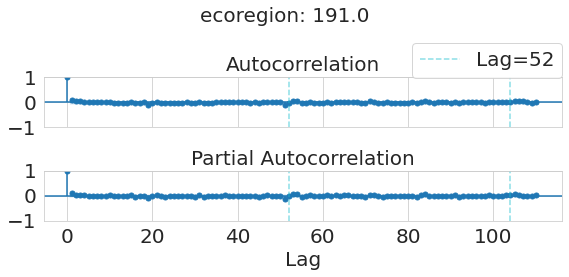

192.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


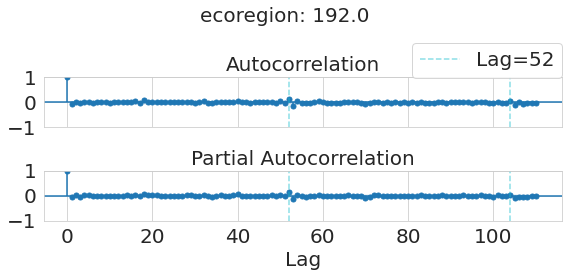

193.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


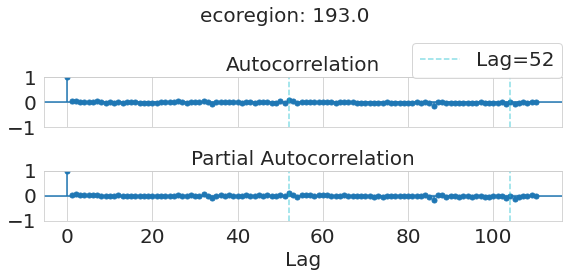

194.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


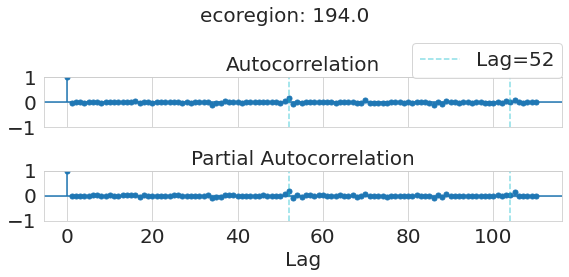

195.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


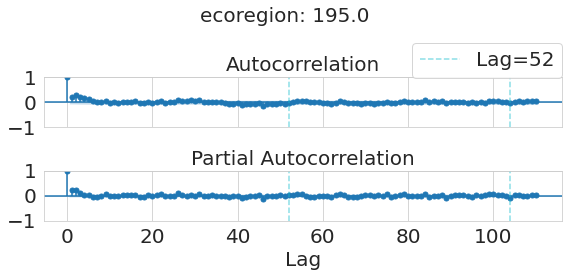

196.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


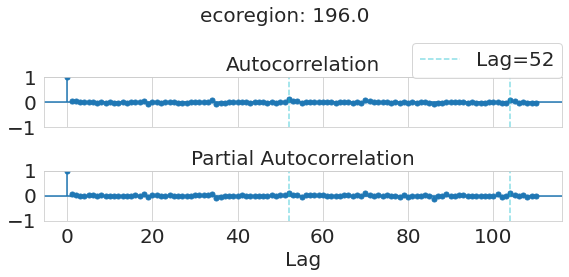

197.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


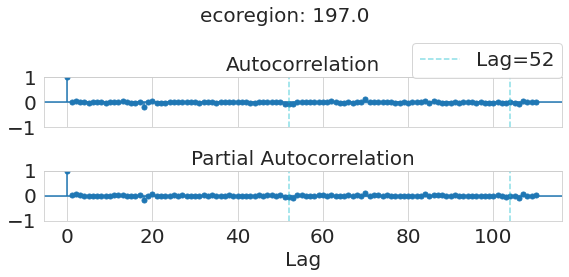

198.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


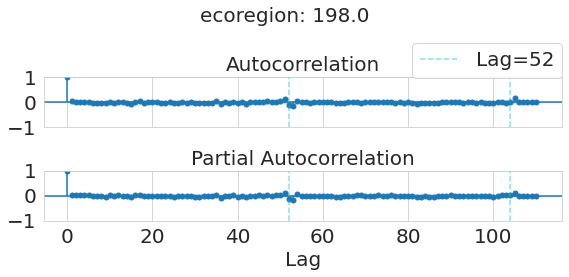

199.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


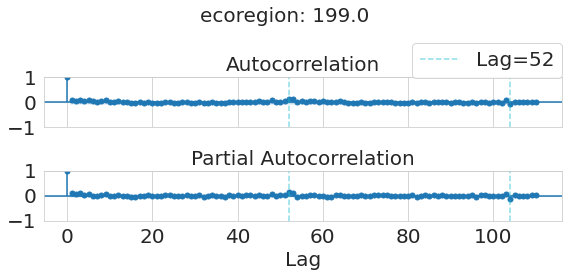

200.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


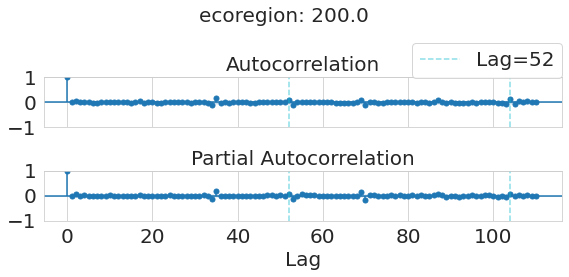

201.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


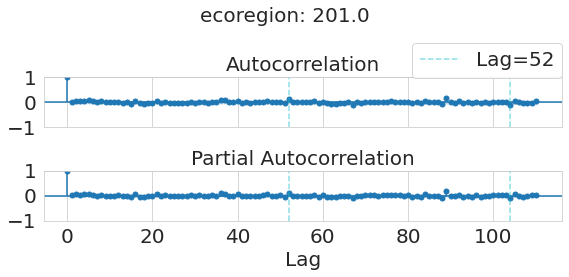

202.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


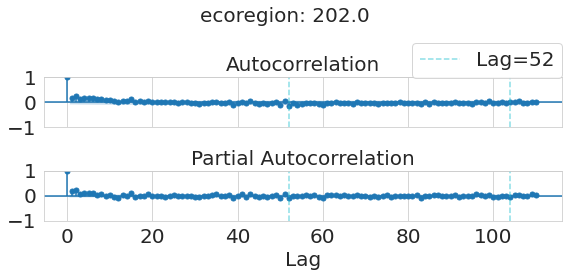

204.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


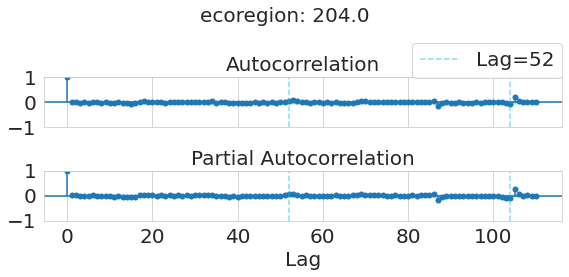

206.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


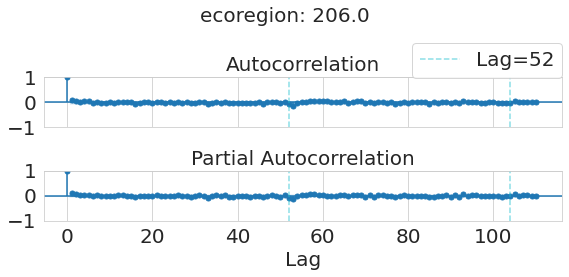

209.0


/home/user/.pyenv/versions/MasterProject-3.9.2/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


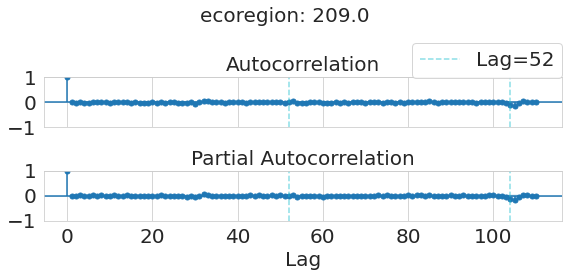

In [7]:
# The second step is to find the values for p and P using ACF and PACF. Since analysing all 68 used ecoregions is 
# computationally expensive and not really necessary, only the eco-regions from the transcom region deemed most reliable are
# included in the analysis. This is the Europe TransCom region, with has the eco-regions 191 to 209.

for region in train_ds.eco_regions.sel(eco_regions= slice(191.0, 210.0)):
    print(str(region.values))
    dat = train_ds.sf_per_eco.loc[dict(eco_regions=region)]
    fig, ax = plt.subplots(2,1, figsize=(8, 4), sharex=True)

    # make ACF plot
    fig = sm.graphics.tsa.plot_acf(dat, lags=110, ax=ax[0])

    # Make PACF plot
    fig = sm.graphics.tsa.plot_pacf(dat, lags=110, ax=ax[1])


    # change the fontsize
    ax[0].tick_params(labelsize=20)
    ax[0].set_title(ax[0].get_title(), fontsize=20)
    ax[1].tick_params(labelsize=20)
    ax[1].set_title(ax[1].get_title(), fontsize=20)
    ax[1].set_xlabel('Lag', fontsize=20)

    # Adding lines at lag=52 and lag=104
    ax[0].vlines([52, 104], -1, 1, color='C09', linestyles='--', alpha=0.5)
    ax[1].vlines([52, 104], -1, 1, color='C09', linestyles='--', label='Lag=52', alpha=0.5)


    # Make the legend
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0., 0.99, 1., -0.1), fontsize=20)
    plt.suptitle('ecoregion: ' + str(region.values), fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(FIG_DIR+f'/(P)AC/{region}.pdf')
    plt.show()

# Conclusions ACF and PACF:
Lets first determine the AR terms of p and P. This is done by looking at the ACF plots.  Generally speaking, a peak is observed around lag=52 and lag=104. This correlates to a seasonal trend of a year. Next to the peaks at 52 and 104, some peaks are also observed at 52+1 and 104+1, indicating that the P should be either 0 or 1. Closer to lag=0, some models also show a peak at either lag=1, lag=2, or both. This indicated that the p value should be 2.

The PACF plots show a very similar trend. Therefore, the MA terms of q and Q are copied from their AR counter parts: q=2 and Q=1.

This means we arrive at our final model: ARIMA(p,d,q)(P,D,Q)<sub>s</sub> = ARIMA(2,0,2)(1,0,1)<sub>52</sub>

Furthermore, it is reasonable that the mean scaling factor always remain approximately 1. Hence, an intercept term is added as well.

# Training the SARIMA models
After the model selection, it is now time to train the models. This is done usinging the startmodel.tsa.SARIMAX model, which uses maximum likelihood estimation to find values for the seasonal and the non-seasonal AR and MA terms.

In [11]:
def make_coef_plot(mod_sum, save_fig = True):
    '''
    The model summary contains valuable information, but can be difficult to interpret. The main area of interest lies within the significance of the coefficients, as a coefficient which is significantly different from 0 is an indication that the model captured some variance within the series of scaling factors. This function provides a plot of the 95% confidence intervals of the model.
    :param mod_sum: Summary of the model
    :param save_fig: Flag used for indicating whether the plot should be saved
    :return: None.
    '''

    # Define the color of the plotted coefficients. Index 0 results in the default blue color
    c_idx = 0

    # Set the alpha values of the coefficients not significantly different from 0.
    non_sign_alpha = 0.2

    # Set the fontsize of the tick labels and legend
    fs = 20

    # Make a pandas dataframe of the relevant table of the model summary
    results_as_html = mod_sum.tables[1].as_html()
    res_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

    # The CI series provides the CI of every coefficient with respect to the mean
    ci_series = res_df.coef - res_df['[0.025']

    # Provide the names of the coefficients
    var_names = ['intercept', r'$\theta_1$', r'$\theta_2$', r'$\phi_1$', r'$\phi_2$', r'$\Theta_1$', r'$\Phi_1$', r'a']

    # Create new dataframe with only the relevant information.
    coef_df = pd.DataFrame({'coef': res_df.coef.values[1:],
                            'ci': ci_series.values[1:],
                            'varname': var_names[1:]
                           })

    # Use a filter which checks whether the CI contains 0 to set the alphas of the coefficients
    alphas = np.where(abs(coef_df.coef) < abs(coef_df.ci), non_sign_alpha, 1)

    # Make the actual plot
    fig, ax = plt.subplots(figsize=(8, 5))
    coef_df.plot(x='varname', y='coef', kind='bar',
                 ax=ax, color='none',
                 yerr='ci', legend=False,
                 error_kw=dict(lw=2, capsize=5, capthick=2))
    ax.set_ylabel('')
    ax.set_xlabel('')

    # Include the CIs as error bars
    ax.scatter(x=pd.np.arange(coef_df.shape[0]),
               alpha=alphas,
               marker='o', s=120,
               y=coef_df['coef'],
               c='C0' + str(c_idx))

    # Add a 0-line for additional clarity
    ax.axhline(y=0, linestyle='--', color='grey', linewidth=2)
    ax.xaxis.set_ticks_position('none')
    plt.xticks(fontsize=fs, rotation=0)
    plt.yticks(fontsize=fs)


    # Group the coefficients according to their functionality within the model.
    ax.annotate('non-seasonal', xy=(2/7, -0.2), xytext=(2/7, -0.4),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=fs, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=6.7, lengthB=1.', lw=2.0, color='black'))

    ax.annotate('seasonal', xy=(5/7, -0.2), xytext=(5/7, -0.4),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=fs, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=3, lengthB=1.', lw=2.0, color='black'))

    ax.annotate('noise', xy=(13/14, -0.2), xytext=(13/14, -0.4),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=fs, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=0.75, lengthB=1.', lw=2.0, color='black'))


    # Create a handle for the significant coefficients
    sign_handle = mpl.lines.Line2D([], [], color="white", marker='o', markersize=20, markerfacecolor="C0"+str(c_idx))

    # Create a handle for the non-significant coefficients
    rgb_col = plt.rcParams['axes.prop_cycle'].by_key()['color'][c_idx]
    rgba_col = rgb_col + str(int(non_sign_alpha*100))
    non_sign_handle = mpl.lines.Line2D([], [], color="white", marker='o', markersize=20, markerfacecolor=rgba_col)

    # Add the legend to the figure
    plt.legend(handles=[sign_handle, non_sign_handle], labels=['CI excludes 0', 'CI includes 0'], loc='upper left', ncol=2, fontsize=fs)
    plt.tight_layout()

    # Save the figure
    if save_fig:
        plt.savefig(FIG_DIR+f'coefficients/{region}.pdf')
        # plt.savefig(FIG_DIR+f'coefficients/{region}.png')

    plt.show()



191.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -1479.856
Date:                              Sat, 19 Nov 2022   AIC                           2975.713
Time:                                      21:44:38   BIC                           3014.025
Sample:                                           0   HQIC                          2990.358
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0178      0.236      0.075      0.940      -0.445       0.481
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


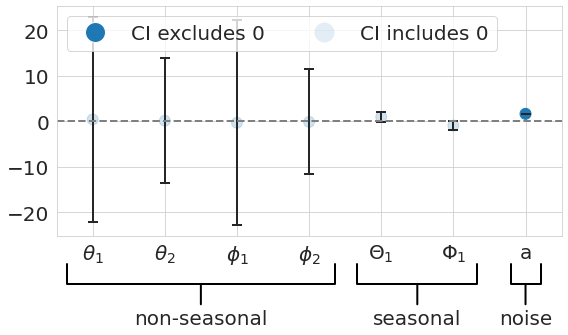


 Making prediction:


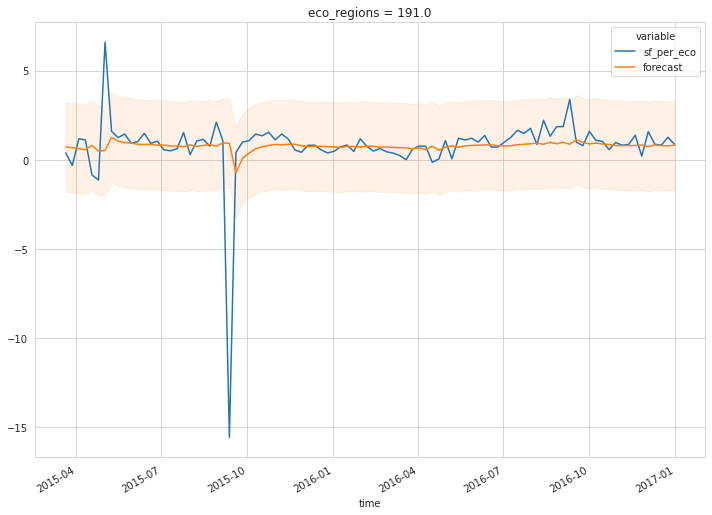

192.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -2077.726
Date:                              Sat, 19 Nov 2022   AIC                           4171.453
Time:                                      21:44:39   BIC                           4209.764
Sample:                                           0   HQIC                          4186.098
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0058     75.025      0.013      0.989    -146.040     148.052
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


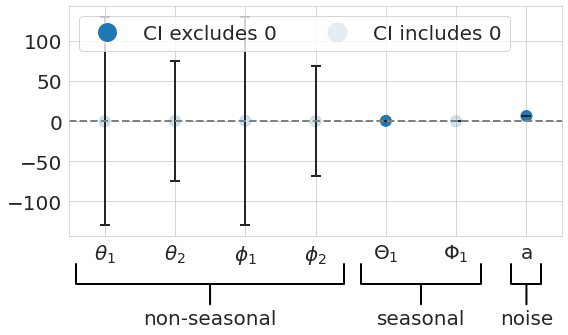


 Making prediction:


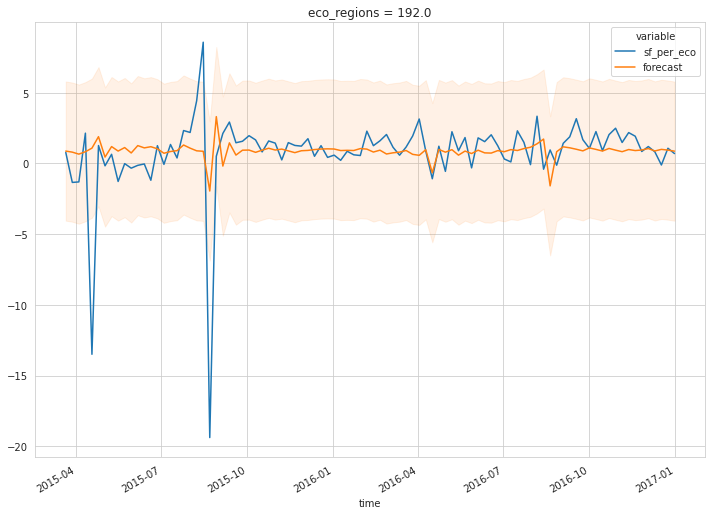

193.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -1545.029
Date:                              Sat, 19 Nov 2022   AIC                           3106.057
Time:                                      21:44:41   BIC                           3144.369
Sample:                                           0   HQIC                          3120.702
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3848      0.594      0.648      0.517      -0.780       1.550
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


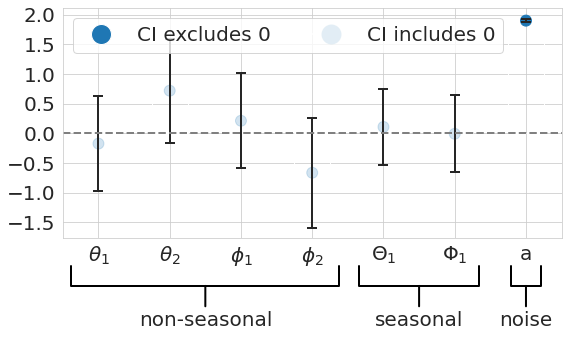


 Making prediction:


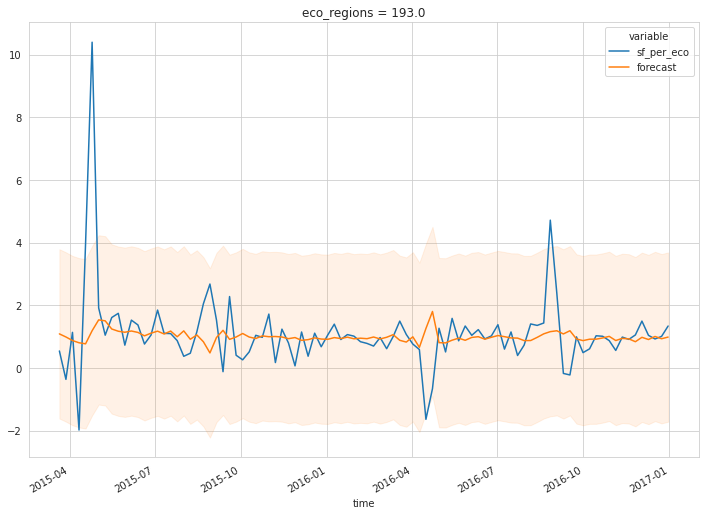

194.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -1758.431
Date:                              Sat, 19 Nov 2022   AIC                           3532.862
Time:                                      21:44:43   BIC                           3571.174
Sample:                                           0   HQIC                          3547.507
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8263      0.276      2.995      0.003       0.286       1.367
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


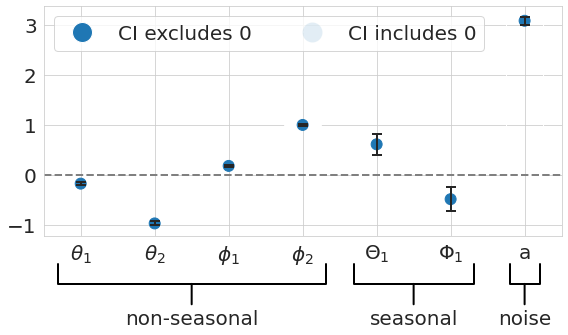


 Making prediction:


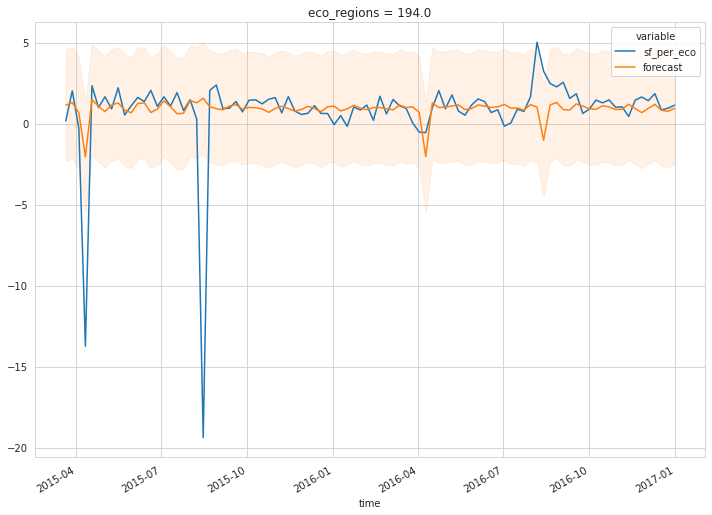

195.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -3013.392
Date:                              Sat, 19 Nov 2022   AIC                           6042.784
Time:                                      21:44:44   BIC                           6081.096
Sample:                                           0   HQIC                          6057.429
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0084      0.017      0.484      0.629      -0.026       0.042
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


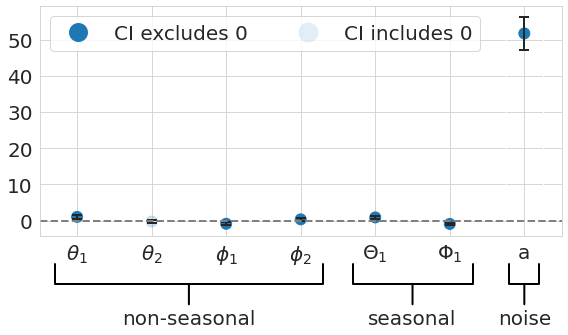


 Making prediction:


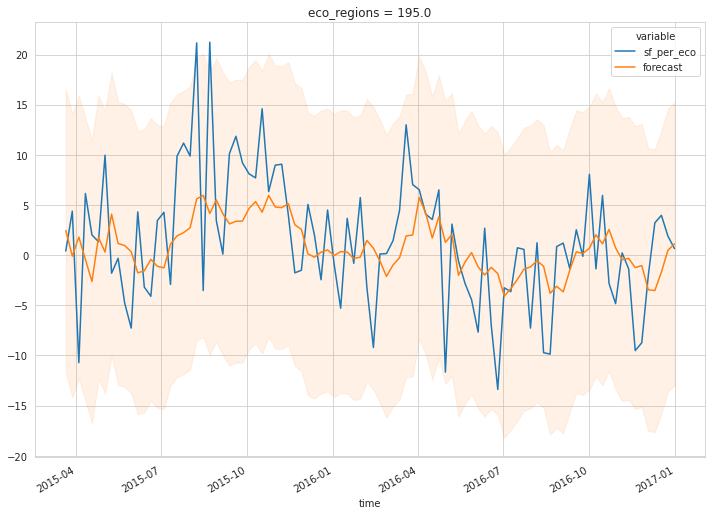

196.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -2248.648
Date:                              Sat, 19 Nov 2022   AIC                           4513.295
Time:                                      21:44:46   BIC                           4551.607
Sample:                                           0   HQIC                          4527.940
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4726      4.141      0.114      0.909      -7.643       8.588
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


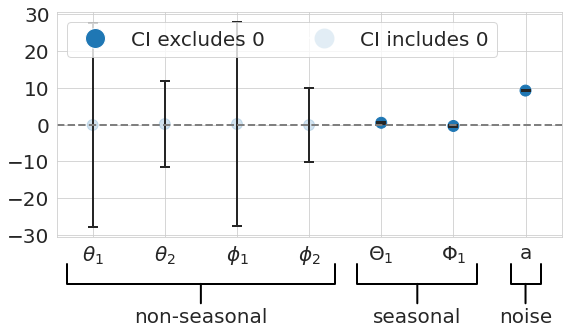


 Making prediction:


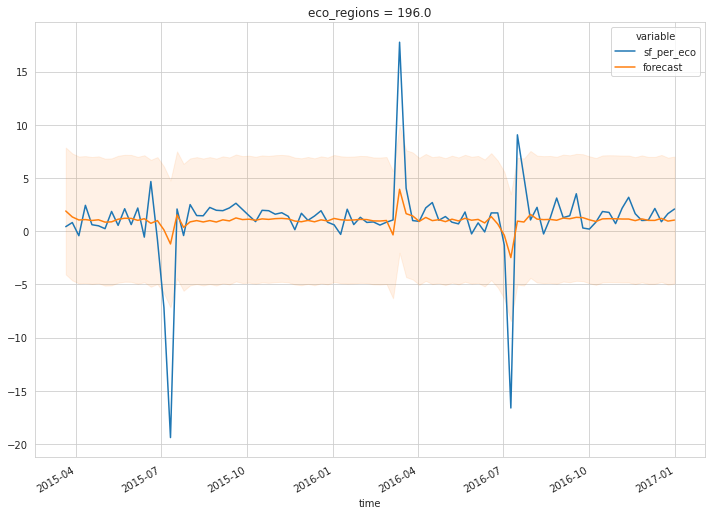

197.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -1977.367
Date:                              Sat, 19 Nov 2022   AIC                           3970.733
Time:                                      21:44:48   BIC                           4009.045
Sample:                                           0   HQIC                          3985.378
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6460      0.303      5.438      0.000       1.053       2.239
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


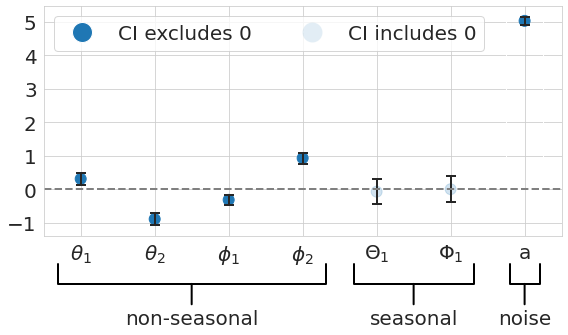


 Making prediction:


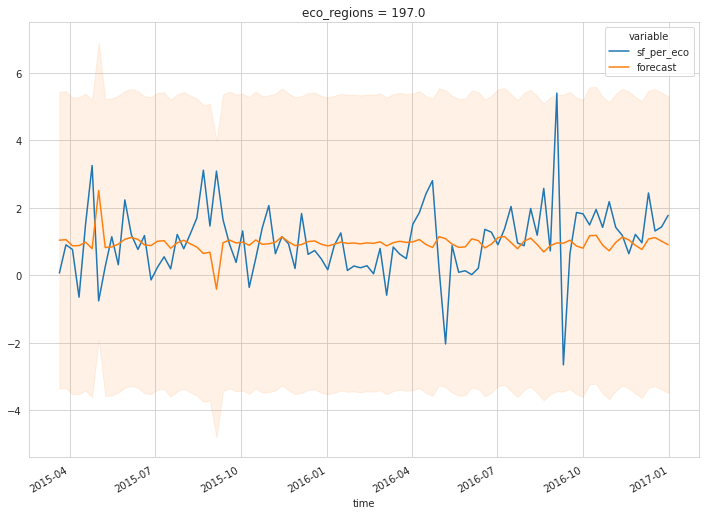

198.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -1722.005
Date:                              Sat, 19 Nov 2022   AIC                           3460.010
Time:                                      21:44:49   BIC                           3498.322
Sample:                                           0   HQIC                          3474.655
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1275      0.056      2.295      0.022       0.019       0.236
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


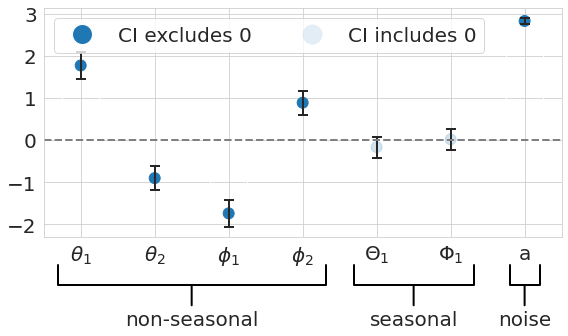


 Making prediction:


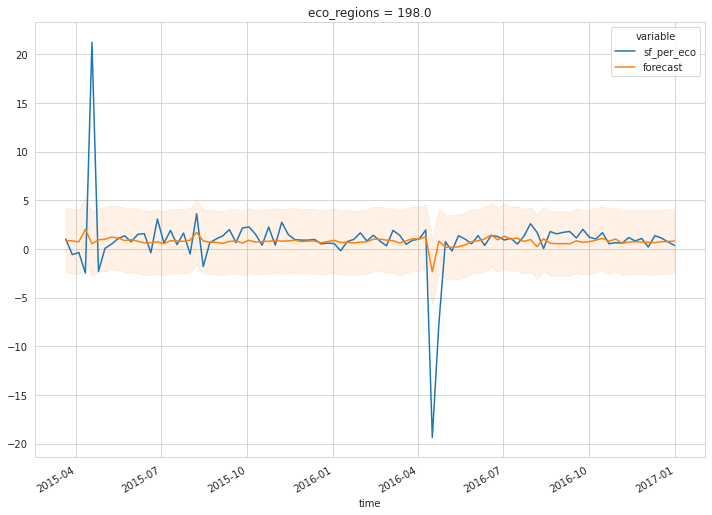

199.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -1792.306
Date:                              Sat, 19 Nov 2022   AIC                           3600.612
Time:                                      21:44:51   BIC                           3638.924
Sample:                                           0   HQIC                          3615.257
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2690      0.213      1.264      0.206      -0.148       0.686
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


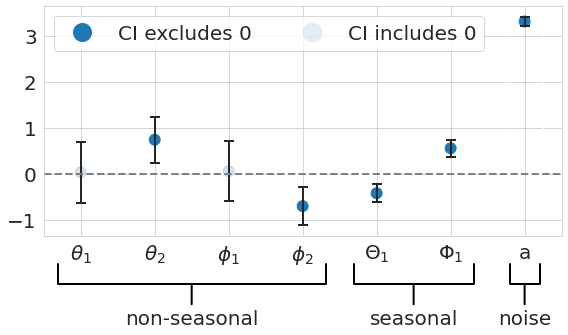


 Making prediction:


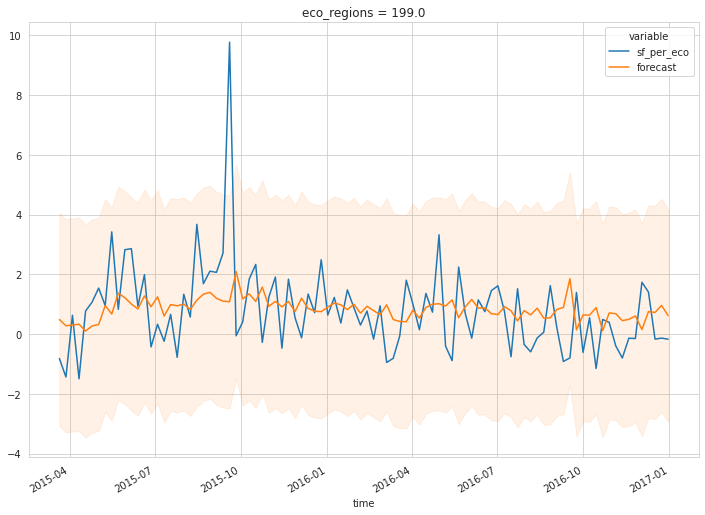

200.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -1698.903
Date:                              Sat, 19 Nov 2022   AIC                           3413.807
Time:                                      21:44:53   BIC                           3452.119
Sample:                                           0   HQIC                          3428.452
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0101      0.037      0.269      0.788      -0.063       0.084
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


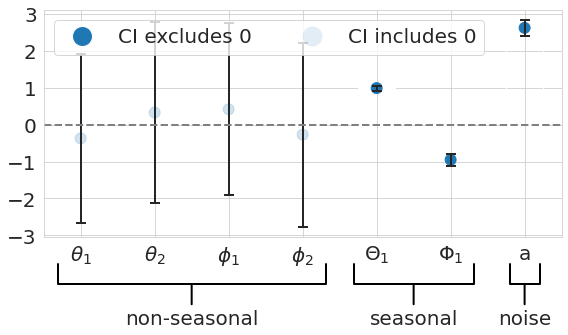


 Making prediction:


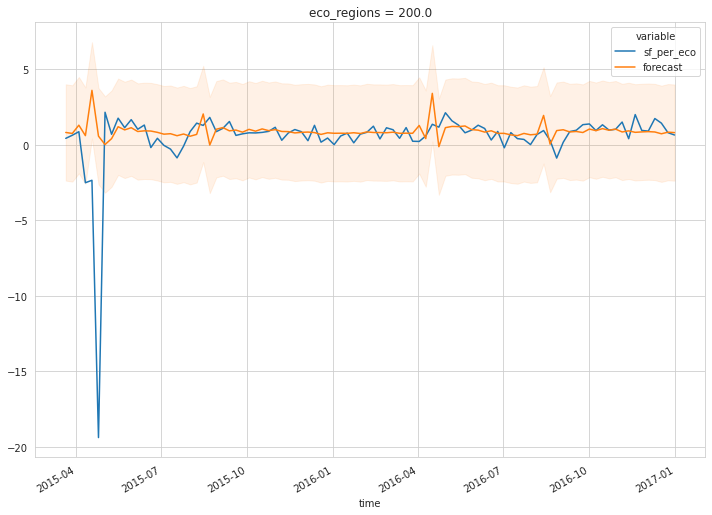

201.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -2087.390
Date:                              Sat, 19 Nov 2022   AIC                           4190.781
Time:                                      21:44:55   BIC                           4229.093
Sample:                                           0   HQIC                          4205.426
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3210      0.232      1.382      0.167      -0.134       0.776
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


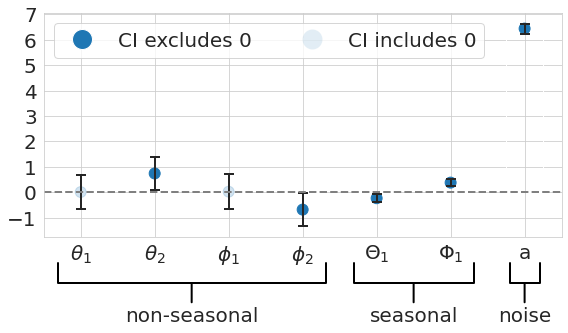


 Making prediction:


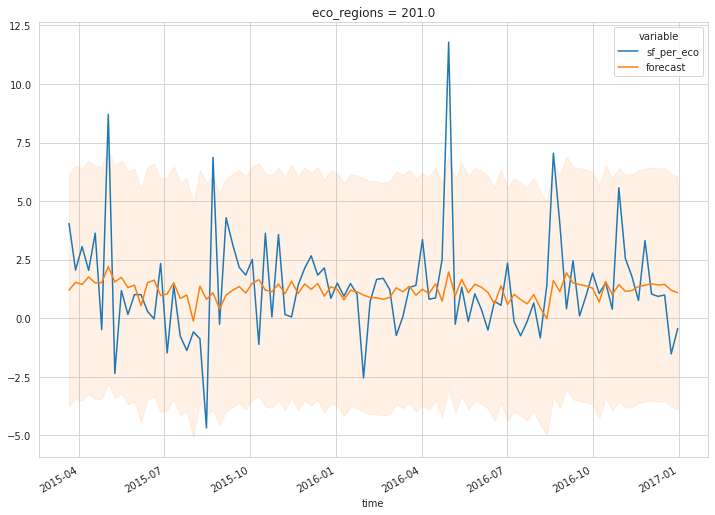

202.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -3014.025
Date:                              Sat, 19 Nov 2022   AIC                           6044.050
Time:                                      21:44:56   BIC                           6082.362
Sample:                                           0   HQIC                          6058.695
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1937      0.113      1.716      0.086      -0.028       0.415
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


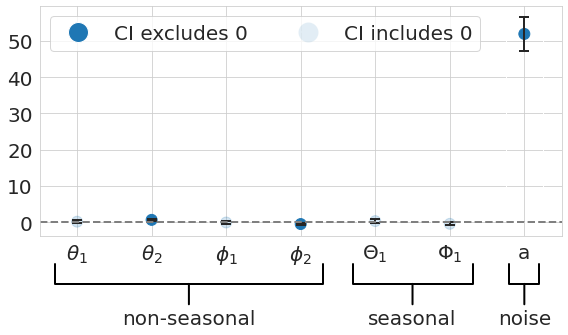


 Making prediction:


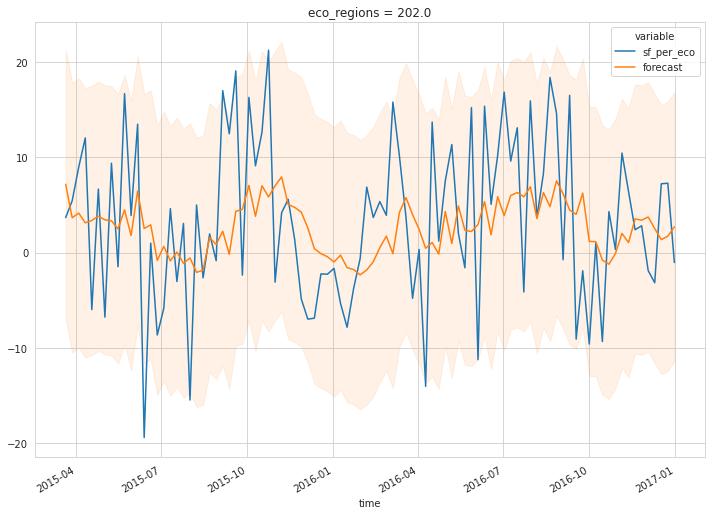

204.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -1473.978
Date:                              Sat, 19 Nov 2022   AIC                           2963.957
Time:                                      21:44:58   BIC                           3002.268
Sample:                                           0   HQIC                          2978.601
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0516      0.423      0.122      0.903      -0.777       0.880
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


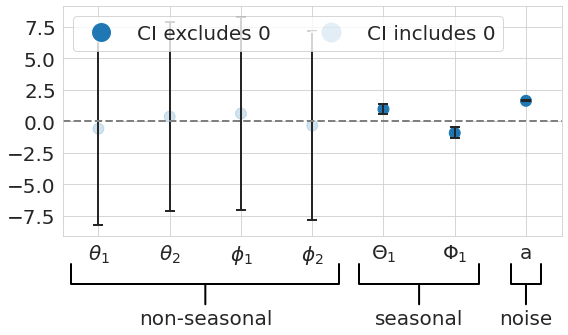


 Making prediction:


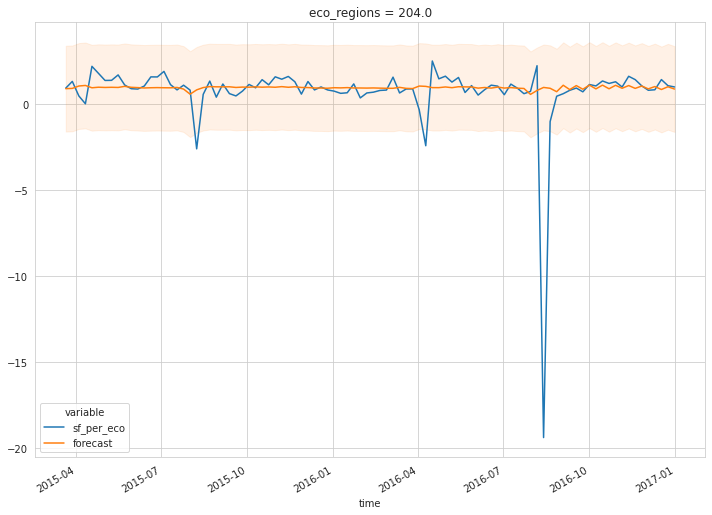

206.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -1978.867
Date:                              Sat, 19 Nov 2022   AIC                           3973.734
Time:                                      21:44:59   BIC                           4012.046
Sample:                                           0   HQIC                          3988.379
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2974      8.093      0.037      0.971     -15.565      16.160
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


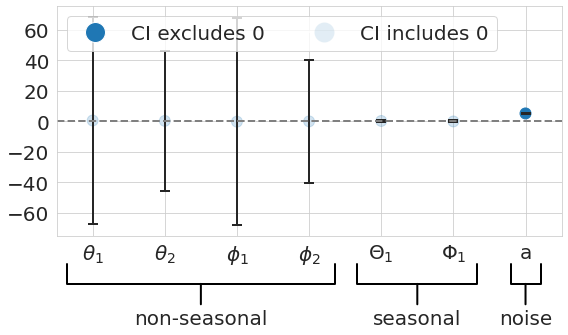


 Making prediction:


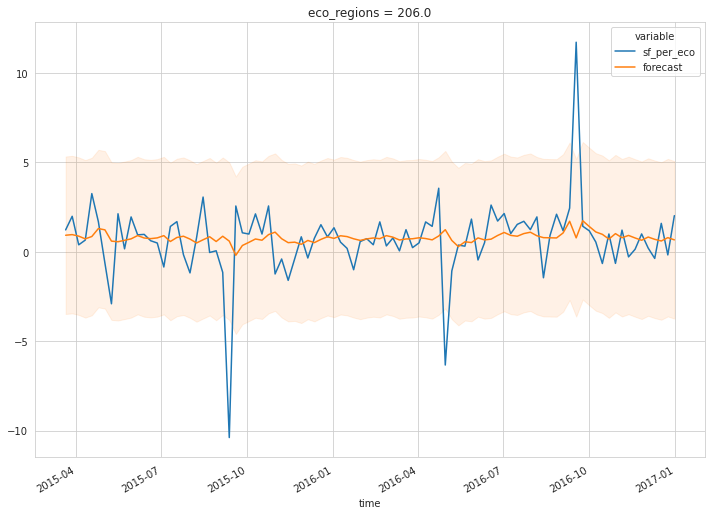

209.0
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  888
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 52)   Log Likelihood               -2183.615
Date:                              Sat, 19 Nov 2022   AIC                           4383.229
Time:                                      21:45:01   BIC                           4421.541
Sample:                                           0   HQIC                          4397.874
                                              - 888                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4979      1.220      1.227      0.220      -0.894       3.890
ar.L1        

/tmp/ipykernel_12629/757498832.py:47: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


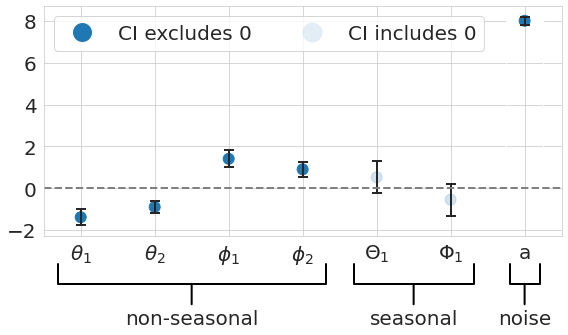


 Making prediction:


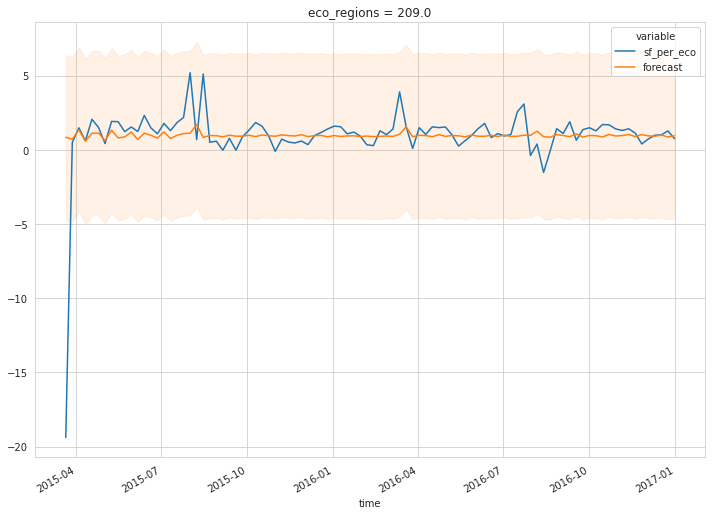

In [14]:
def load_model(region, data):
    '''
    Function for loading previously trained SARIMA models
    :param region: Provide the region ID of the trained SARIMA model
    :param data: The SARIMA implementation requires that the data to which the model is applied is provided when initializing the model
    :return: The trained SARIMA model
    '''
    model_path = pers_file_dir+'SARIMA/2000/SARIMA_'+region+'.pkl'
    with open(model_path, 'rb') as f:
        model = pkl.load(f)
        trained_model = sm.tsa.SARIMAX(data.values,
                                     order=(2,0,2),             # Defining the regular AR, I and MA dependencies
                                     seasonal_order=(1,0,1,52), # Defining the seasonal dependencies
                                     trend = 'c'                # Adding an intercept term
                                     )
        trained_model = trained_model.filter(model)
    return trained_model

# Only analyze the ecoregion within the Europe TransCom region.
for region in train_ds.eco_regions.sel(eco_regions= slice(191.0, 209.0)):
    print(str(region.values))
    data = train_ds.sf_per_eco.loc[dict(eco_regions=region)]

    # Check whether an already trained model is available. If so, load this model. If not, train a new model.
    try:
        trained_model = load_model(str(region.values), data)
    except ImportError:
        print('could not load previously trained model. Loading new one')

        model = sm.tsa.statespace.SARIMAX(data.values,
                                         order=(2,0,2),             # Defining the regular AR, I and MA dependencies
                                         seasonal_order=(1,0,1,52), # Defining the seasonal dependencies
                                         trend = 'c'                # Adding an intercept term
                                         )
        print(model)
        trained_model=model.fit(maxiter=100) # method='cg'

    # Print the model sumary
    print(trained_model.summary())

    # Make the coeffients plots for easier analysis
    make_coef_plot(trained_model.summary())

    # Make a plot of the fit of the model to the final two years of training data
    prediction = trained_model.get_prediction(start=794)
    pred_ci = prediction.conf_int()
    pred_dat = prediction.predicted_mean

    print('\n Making prediction:')
    forecast = xr.DataArray(data = pred_dat, 
                            dims = ['time'],
                            coords = dict(time=data.time.isel(time=slice(794,888))),
                            name = 'forecast')

    # Plotting the predictions to give insights on the fit to the training data.
    xr.merge([data, forecast]).isel(time=slice(794,888)).to_array().plot.line(x='time',figsize=(12,8))

    # Adding the uncertainty interval
    plt.fill_between(data.time.isel(time=slice(794,888)).values, pred_ci[:,0], pred_ci[:,1], color='C01', alpha=0.1)
    plt.show()


A closer inspection of the summaries of the models show that there is large difference in the probabilities for the coefficients being non-zero. While for some models almost all coefficients are not significantly different from 0 (e.g. model 191.0), other models have only coefficients significantly different from 0 (e.g. model 194.0). What all models have in common, is that the sigma2 term, which is an indication of the remaining unexplained variance, is for all models significantly larger than 0. This is an indication that to models provide a poor fit to the training data and additional analysis is needed to determine whether a better model can be found. This is done by checking for dependencies within the residuals.

The Ljung-box test tests whether a significant correlation exists between the residuals at various lags. If this is the case, it is likely that including additional parameters could provide a better model fit. If no significant correlations are found, it is safe to assume the remaining residuals are essentially white noise and thus no further improvement can be achieved.


In [15]:
for region, data in train_ds.loc[dict(eco_regions=slice(190.0, 209.0))].sf_per_eco.groupby('eco_regions'):
    print(region)
    trained_model = load_model(str(region), data)

    print(f'region: {region} - \n{sm.stats.acorr_ljungbox(trained_model.resid, lags=[110], return_df=True)}')

191.0
region: 191.0 - 
       lb_stat  lb_pvalue
110  63.909939   0.999867
192.0
region: 192.0 - 
       lb_stat  lb_pvalue
110  72.697399   0.997651
193.0
region: 193.0 - 
       lb_stat  lb_pvalue
110  67.640996   0.999498
194.0
region: 194.0 - 
       lb_stat  lb_pvalue
110  83.847037   0.969969
195.0
region: 195.0 - 
        lb_stat  lb_pvalue
110  137.104923    0.04094
196.0
region: 196.0 - 
       lb_stat  lb_pvalue
110  82.124408   0.978346
197.0
region: 197.0 - 
       lb_stat  lb_pvalue
110  71.481546   0.998339
198.0
region: 198.0 - 
        lb_stat  lb_pvalue
110  103.533598   0.655283
199.0
region: 199.0 - 
       lb_stat  lb_pvalue
110  66.249954   0.999688
200.0
region: 200.0 - 
       lb_stat  lb_pvalue
110  93.591881   0.868863
201.0
region: 201.0 - 
        lb_stat  lb_pvalue
110  123.353807   0.181203
202.0
region: 202.0 - 
        lb_stat  lb_pvalue
110  133.256429   0.065067
204.0
region: 204.0 - 
        lb_stat  lb_pvalue
110  120.504251   0.232252
206.0
region: 2

Using the Ljung-box test, we find that only the residuals of the model of ecoregion 195.0 contains dependencies. Closer inspection on this ecoregion find that this ecoregions only makes up 0.1% of the total surface of Europe. As such, the contribution of this ecoregion to the total flux landscape is limited. Adding more parameters to all other models only to try and improve the performance on this ecoregion would therefore add unnecessary complexity.

Therefore, the ARIMA(2,0,2)(1,0,1)<sub>52</sub> model is chosen to be the model used for the remainder of the thesis.